In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import re
from difflib import SequenceMatcher
import os

path = 'C:/Users/calvi/Documents/590F - Digital Forensics/Project'
files = []
for i in os.listdir(path):
    if os.path.isfile(os.path.join(path,i)) and 'WhatsApp Chat with' in i:
        files.append(i)

In [2]:
dataframes = []

for file in files:

    with open(file, 'r', encoding='utf-8') as myfile:

        data = myfile.read()
        texts = data.split('\n')

        texts = texts[1:]

        rev_texts = texts[::-1]

        for ix,text in enumerate(rev_texts):
            dt_str = text.split('-')[0][:-1]
            matchObj = re.match( r'././.., ..:..', dt_str)
            
            if not matchObj:
                try:
                    rev_texts[ix+1] += ' ' + text
                except:
                    pass

        texts = rev_texts[::-1]

        cleaned_texts = []

        for text in texts:
            matchObj = re.match( r'.+ .+/.+/.., ..:.. .*', text)
            if matchObj:
                month = text.split('/')[0]
                date = text.split('/')[1]
                t_text = text.split('/')[2][:-2]
                if t_text[-4:] != 'http':
                    truncated_text = month + '/' + date + '/' + t_text
                else:
                    year = text.split('/')[2][:2]
                    rest = text.split(',')[1][:-8]
                    truncated_text = month + '/' + date + '/' + year + ',' + rest
                cleaned_texts.append(truncated_text)
            else:
                cleaned_texts.append(text)

        final_texts = []

        for c_text in cleaned_texts:
            matchObj = re.match( r'[123456789]+/.+/.., ..:.. .*', c_text)
            if matchObj:
                final_texts.append(c_text)

        datetimes = []

        for text in final_texts:
            dt_str = text.split('-')[0][:-1]
            formatted_dt = dt.datetime.strptime(dt_str,"%m/%d/%y, %H:%M")
            datetimes.append(formatted_dt)

        pure_texts = []
        senders = []

        for text in final_texts:

            num_splits = len(text.split('-'))
            pure_msg = ''
            for sp in range(num_splits)[1:]:
                pure_msg += text.split('-')[sp]
            pure_msg = pure_msg[1:]

            sender = pure_msg.split(':')[0]

            num_sp = len(pure_msg.split(':'))
            abs_pure_msg = ''
            for spl in range(num_sp)[1:]:
                abs_pure_msg += pure_msg.split(':')[spl]
            abs_pure_msg = abs_pure_msg[1:]

            pure_texts.append(abs_pure_msg)
            senders.append(sender)

        chat_db = pd.DataFrame(np.column_stack([datetimes,senders,pure_texts]), 
                                   columns=['Date/Time','Sender','Message'])
        
        dataframes.append(chat_db)


In [3]:
master_db = pd.concat(dataframes)

In [4]:
with open('textsbetween.txt', 'r', encoding='utf-8') as myfile:
    dt_data = myfile.read()
    dts = dt_data.split('\n')
    dt1 = dts[0]
    dt2 = dts[1]

In [5]:
def find_texts_between(dt_str_1, dt_str_2, df):
    dt1 = dt.datetime.strptime(dt_str_1,"%m/%d/%y, %H:%M")
    dt2 = dt.datetime.strptime(dt_str_2,"%m/%d/%y, %H:%M")
    result_db = df.loc[(df['Date/Time'] >= dt1) & (df['Date/Time'] <= dt2)]
    return result_db

In [6]:
extract = find_texts_between(dt1,dt2,master_db)

In [7]:
extract.head()

,Date/Time,Sender,Message
1022,2018-02-27 00:00:00,Armzie Shaan,Okay.. Just Pls listen to me and take care of ...
1023,2018-02-27 00:00:00,Ajay Shaan,I understand honey.. 😢 I promise I'll sleep we...
1024,2018-02-27 00:00:00,Ajay Shaan,Yes luv.. ❤❤❤❤❤
1025,2018-02-27 08:05:00,Armzie Shaan,Shany boo boo.. Can we cam chat again tonight?...
1026,2018-02-27 08:06:00,Ajay Shaan,.*I won't forget you in my life* for all your...


In [8]:
with open('searchwords.txt', 'r', encoding='utf-8') as myfile:
    search_data = myfile.read()
    search_terms = search_data.split('\n')        

In [9]:
search_terms

['kitty', 'shany', 'storm']

In [10]:
def find_texts_containing(search_terms, df):
    def record_hit(row):
        hit = 0
        bag_of_words = row['Message'].split(' ')
        for s_term in search_terms:
            for word in bag_of_words:
                if SequenceMatcher(None, s_term, word).ratio() > 0.75:
                    hit = 1
                    break
        return hit
    result_db = df
    result_db['Hit'] = result_db.apply(record_hit,axis=1)
    result_db = result_db.loc[result_db['Hit']==1]
    return result_db[['Date/Time','Sender','Message']]

In [11]:
extract = find_texts_containing(search_terms,master_db)

In [12]:
extract

,Date/Time,Sender,Message
56,2018-02-07 22:59:00,Ajay Shaan,Me when I think of my Kitty 😍
66,2018-02-07 23:06:00,Ajay Shaan,Aawwww.. Is my Kitty hungry? Do you wanna have...
142,2018-02-10 03:45:00,Ajay Shaan,"Until then, stay strong.. Armzie and Shany for..."
144,2018-02-10 09:38:00,Ajay Shaan,"My silly Kitty cat, that's not what I want! Of..."
169,2018-02-10 21:36:00,Armzie Shaan,Plan? 😯 hmm.. Alright Shany I've wasted your t...
170,2018-02-10 21:38:00,Ajay Shaan,"No honey, every minute I spend talking to you ..."
202,2018-02-11 23:29:00,Armzie Shaan,Shany baby.. 😘😚❤ we're having lunch now...
218,2018-02-12 20:29:00,Armzie Shaan,Morning babe.. 😚 its another beautiful day mad...
262,2018-02-14 01:14:00,Ajay Shaan,Give me yourself! You're the cutest Kitty evah! 😍
276,2018-02-14 03:34:00,Ajay Shaan,"Luv, please watch the video I sent you on FB....."


In [38]:
def chrono_sort(df,order):
    if order == 'asc':
        chrono_df = df.sort_values(['Date/Time'])
    elif order == 'des':
        chrono_df = df.sort_values(['Date/Time'],ascending=False)
    return chrono_df

In [39]:
extract = chrono_sort(master_db,'des')
extract

,Date/Time,Sender,Message,Hit
5192,2018-04-24 12:48:00,Mom,Be happy always,0
5193,2018-04-24 12:48:00,Ajay Shaan,Of course! I tell you and Dad the same.. 😘,0
5191,2018-04-24 12:47:00,Mom,❤😘👍,0
5190,2018-04-24 12:47:00,Ajay Shaan,Thanks ma! 😊,0
5189,2018-04-24 12:45:00,Mom,Ok chellam... Have a great day ma😘❤,0
5188,2018-04-24 12:44:00,Ajay Shaan,Good night ma! Sleep well and wake up to a bea...,0
5187,2018-04-24 12:44:00,Mom,❤😘👍😊,0
5186,2018-04-24 12:44:00,Mom,Going to bed..,0
36,2018-04-24 11:03:00,Kirtika,🤣🤣🤣🤣,0
35,2018-04-24 10:54:00,Ajay Shaan,Cycling IS the ideal way to commute in Bangalo...,0


In [13]:
def find_links(df):
    def record_hit(row):
        hit = 0
        hyperlink_match = re.match(r'.*http.*', row['Message'])
        if hyperlink_match:
            hit =1
        return hit
    result_db = df
    result_db['Hit'] = result_db.apply(record_hit,axis=1)
    result_db = result_db.loc[result_db['Hit']==1]
    return result_db[['Date/Time','Sender','Message']]

In [14]:
extract = find_links(master_db)
extract

,Date/Time,Sender,Message
76,2017-06-30 12:35:00,Apoorva,https//youtu.be/kGbcrc4uZ4o
81,2017-07-05 12:22:00,Apoorva,https//youtu.be/kJQP7kiw5Fk
94,2017-07-06 23:53:00,Apoorva,"Parthasarathy Damodar Party Hall No. 376, K62,..."
293,2017-11-09 21:48:00,Apoorva,https//vimeo.com/241310533
294,2017-11-09 21:48:00,Apoorva,https//drive.google.com/open?id=0BzjjGmcA7V3zc...
1,2018-02-06 21:56:00,Ajay Shaan,"You have to listen to this prank, it's hilario..."
8,2018-02-06 23:01:00,Armzie Shaan,Check out this item I found on Lazada! Huion H...
36,2018-02-07 17:38:00,Ajay Shaan,https//9gag.com/
446,2018-02-16 19:46:00,Armzie Shaan,https//youtu.be/KTosDIMEF24
465,2018-02-16 20:06:00,Ajay Shaan,https//www.polygon.com/2016/4/20/11466700/dark...


In [15]:
def find_phone_nums(df):
    def record_hit(row):
        hit = 0
        phone_num_match_1 = re.match(r'.*[0123456789]{10,12}.*', row['Message'])
        phone_num_match_2 = re.match(r'.*[0123456789]{3,4}-[0123456789]{3,4}-[0123456789]{3,4}.*', row['Message'])
        if phone_num_match_1 or phone_num_match_2:
            hit =1
        return hit
    result_db = df
    result_db['Hit'] = result_db.apply(record_hit,axis=1)
    result_db = result_db.loc[result_db['Hit']==1]
    return result_db[['Date/Time','Sender','Message']]

In [16]:
extract = find_phone_nums(master_db)
extract

,Date/Time,Sender,Message
855,2018-02-24 23:58:00,Armzie Shaan,09218313948
856,2018-02-24 23:58:00,Armzie Shaan,09210313948
2624,2018-03-18 02:43:00,Armzie Shaan,https//www.google.com.ph/amp/s/kotaku.com/dark...
4426,2018-04-10 23:14:00,Ajay Shaan,4136952789
10,2017-04-10 06:35:00,Dad,Mom's particulars ...............................
244,2017-06-24 01:19:00,Dad,https//m.facebook.com/groups/1146726018709102?...
287,2017-07-19 09:36:00,Dad,காரில் ஏறியதும் A.C போடாதீர்கள் மருத்துவா்.ஜெ....
327,2017-08-23 06:47:00,Dad,Once again Congrats and Welcome to USA 😀 Anyti...
364,2017-08-25 14:34:00,Dad,"Ajay, Once again Congrats and Welcome to USA 😀..."
374,2017-08-25 21:40:00,Ajay Shaan,It's +14136952789 😁


In [17]:
def find_email_ids(df):
    def record_hit(row):
        hit = 0
        email_match = re.match(r'.*@.{3,15}.com.*', row['Message'])
        if email_match:
            hit =1
        return hit
    result_db = df
    result_db['Hit'] = result_db.apply(record_hit,axis=1)
    result_db = result_db.loc[result_db['Hit']==1]
    return result_db[['Date/Time','Sender','Message']]

In [18]:
extract = find_email_ids(master_db)
extract

,Date/Time,Sender,Message
245,2018-02-14 00:59:00,Ajay Shaan,armelaescalona@gmail.com
2826,2018-03-21 07:35:00,Ajay Shaan,And the email ID is that embarrassing teenageh...
2860,2018-03-21 07:55:00,Ajay Shaan,ajayshaanshanmugam@gmail.com
2962,2018-03-21 15:30:00,Ajay Shaan,Both email IDs are the same.. Funny right? I t...
4049,2018-04-06 14:57:00,Armzie Shaan,same luvv.. armelaescalona@gmail.com
4410,2018-04-10 23:01:00,Ajay Shaan,calvinhendrick@ymail.com
4418,2018-04-10 23:06:00,Ajay Shaan,ajayshaan.shanmugam@gmail.com
0,2017-04-08 05:17:00,Ajay Shaan,calvinhendrick@ymail.com
12,2017-04-12 02:36:00,Ajay Shaan,ajay.shaan.shanmugam@accenture.com
98,2017-04-15 05:45:00,Ajay Shaan,calvinhendrick@ymail.com


In [19]:
sender = 'Ajay Shaan'

# Visualization 1

In [20]:
contacts = []

for file in files:
    contact = file.split('.')[0][19:]
    contacts.append(contact)

sent_to = []
received_from = []

for ix,df in enumerate(dataframes):
    r_from = df[df['Sender']==contacts[ix]].shape[0]
    received_from.append(r_from)
    s_to = df[df['Sender']==sender].shape[0]
    sent_to.append(s_to)

In [21]:
from bokeh.core.properties import value
from bokeh.io import show, output_file
from bokeh.models import ColumnDataSource
from bokeh.plotting import figure
from bokeh.transform import dodge

output_file("visualization_1.html")

data = {'Contacts' : contacts,
        'Sent to'   : sent_to,
        'Received from'   : received_from,
        }

source = ColumnDataSource(data=data)

p = figure(x_range=contacts, plot_height=600, plot_width=1000, title="Number of texts sent to and received from each contact",
           toolbar_location=None, tools="")

p.vbar(x=dodge('Contacts', -0.25, range=p.x_range), top='Sent to', width=0.2, source=source,
       color="#c9d9d3", alpha=0.6, legend=value("Sent to"))

p.vbar(x=dodge('Contacts',  0.0,  range=p.x_range), top='Received from', width=0.2, source=source,
       color="#718dbf", alpha=0.6, legend=value("Received from"))

p.x_range.range_padding = 0.1
p.xgrid.grid_line_color = None
p.legend.location = "top_left"
p.legend.orientation = "horizontal"

show(p)

# Visualization 2

In [22]:
from bokeh.palettes import Category10
import itertools

def color_gen():
    yield from itertools.cycle(Category10[10])
color = color_gen()

p = figure(plot_width=1000, plot_height=600, title='Number of texts sent to and received from each contact per date')

for ix,dframe in enumerate(dataframes):
    dframe['Date'] = dframe['Date/Time'].dt.date
    agg_df = dframe.groupby(['Date']).count()
    
    import pandas as pd
    from math import pi
    from datetime import datetime as dt
    from bokeh.io import output_file
    from bokeh.models import DatetimeTickFormatter
    from bokeh.plotting import figure,show

    p.line(agg_df.index, agg_df['Message'],line_color=next(color), line_width=4, line_alpha=0.6, legend=contacts[ix])

p.xaxis.formatter=DatetimeTickFormatter(
        hours=["%d %B %Y"],
        days=["%d %B %Y"],
        months=["%d %B %Y"],
        years=["%d %B %Y"],
    )
p.xaxis.major_label_orientation = pi/4
p.legend.location = "top_left"
p.legend.orientation = "horizontal"
output_file('visualization_2.html')
show(p)

# Visualization 3

In [23]:
contacts = []

for file in files:
    contact = file.split('.')[0][19:]
    contacts.append(contact)

sent_to_hits = []
received_from_hits = []

for ix,df in enumerate(dataframes):
    hits_df = find_texts_containing(search_terms,df)
    r_from = hits_df[hits_df['Sender']==contacts[ix]].shape[0]
    received_from_hits.append(r_from)
    s_to = hits_df[hits_df['Sender']==sender].shape[0]
    sent_to_hits.append(s_to)

In [24]:
from bokeh.core.properties import value
from bokeh.io import show, output_file
from bokeh.models import ColumnDataSource
from bokeh.plotting import figure
from bokeh.transform import dodge

output_file("visualization_3.html")

data = {'Contacts' : contacts,
        'Sent to'   : sent_to_hits,
        'Received from'   : received_from_hits,
        }

source = ColumnDataSource(data=data)

p = figure(x_range=contacts, plot_height=600,plot_width=1000, title="Number of search hits on texts sent to and received from each contact",
           toolbar_location=None, tools="")

p.vbar(x=dodge('Contacts', -0.25, range=p.x_range), top='Sent to', width=0.2, source=source,
       color="#c9d9d3", alpha=0.6, legend=value("Sent to"))

p.vbar(x=dodge('Contacts',  0.0,  range=p.x_range), top='Received from', width=0.2, source=source,
       color="#718dbf", alpha=0.6, legend=value("Received from"))

p.x_range.range_padding = 0.1
p.xgrid.grid_line_color = None
p.legend.location = "top_left"
p.legend.orientation = "horizontal"

show(p)

# Visualization 4

In [25]:
from bokeh.palettes import Category10
import itertools

def color_gen():
    yield from itertools.cycle(Category10[10])
color = color_gen()

p = figure(plot_width=1000, plot_height=600, title='Number of search hits on texts sent to and received from each contact per date')

for ix,dframe in enumerate(dataframes):
    hits_dframe = find_texts_containing(search_terms,dframe)
    try:
        hits_dframe['Date'] = hits_dframe['Date/Time'].dt.date
    except:
        continue
    agg_df = hits_dframe.groupby(['Date']).count()
    
    import pandas as pd
    from math import pi
    from datetime import datetime as dt
    from bokeh.io import output_file
    from bokeh.models import DatetimeTickFormatter
    from bokeh.plotting import figure,show

    p.line(agg_df.index, agg_df['Message'],line_color=next(color), line_width=4, line_alpha=0.6, legend=contacts[ix])

p.xaxis.formatter=DatetimeTickFormatter(
        hours=["%d %B %Y"],
        days=["%d %B %Y"],
        months=["%d %B %Y"],
        years=["%d %B %Y"],
    )
p.xaxis.major_label_orientation = pi/4
p.legend.location = "top_left"
p.legend.orientation = "horizontal"
output_file('visualization_4.html')
show(p)

# Visualization 5

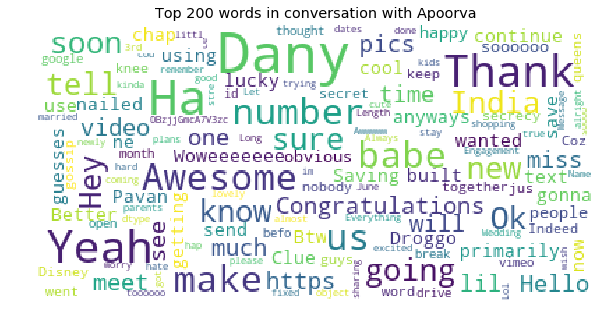

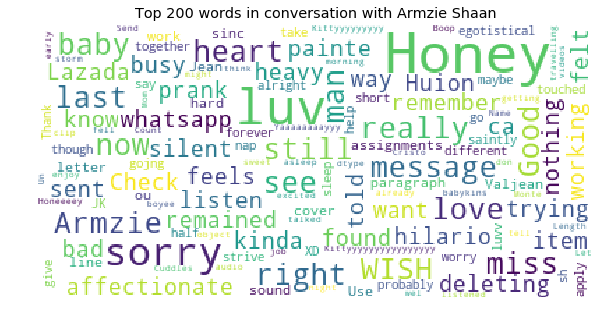

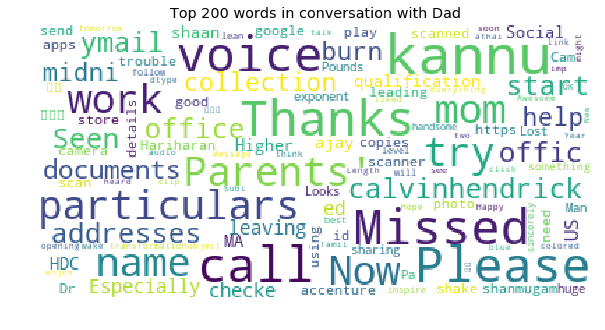

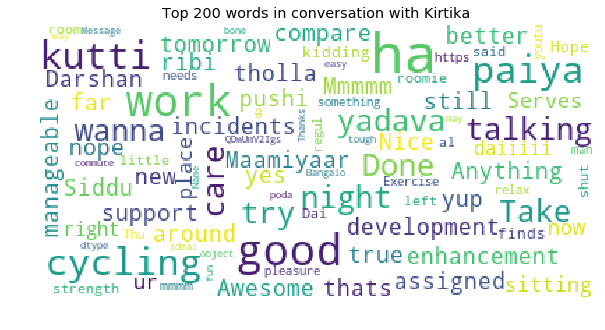

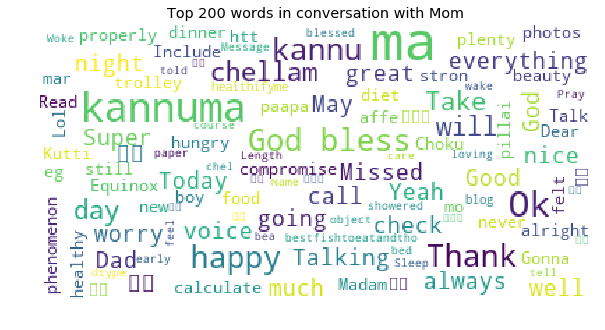

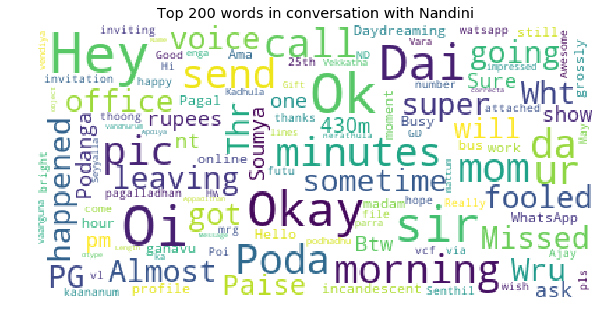

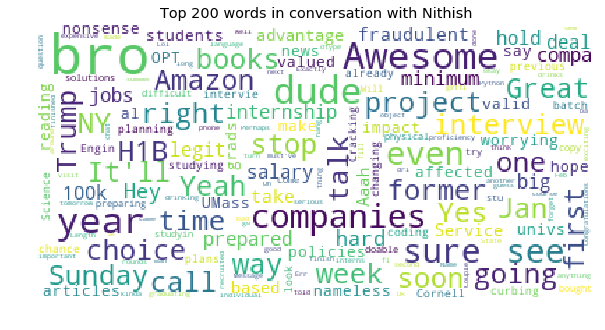

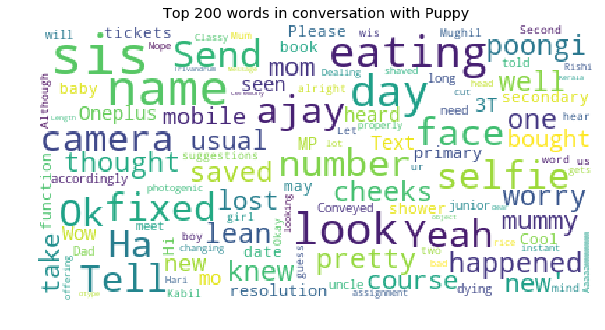

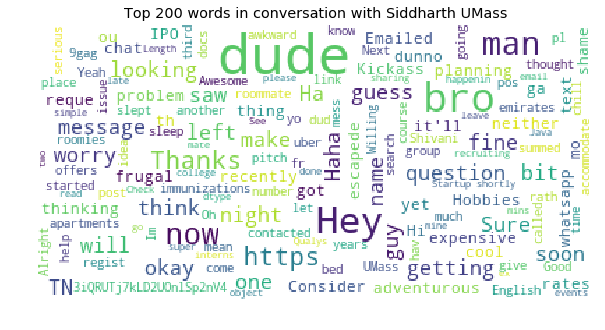

In [26]:
for ix,df in enumerate(dataframes):

    import numpy as np
    import pandas as pd 
    import matplotlib as mpl
    import matplotlib.pyplot as plt
    %matplotlib inline

    from subprocess import check_output
    from wordcloud import WordCloud, STOPWORDS

    mpl.rcParams['figure.figsize']=(10.0,10.0)
    mpl.rcParams['font.size']=12                 
    mpl.rcParams['savefig.dpi']=100             
    mpl.rcParams['figure.subplot.bottom']=.1 


    stopwords = set(STOPWORDS)
    stopwords = stopwords.union(['Media','omitted',contacts[ix]])

    wordcloud = WordCloud(
                              background_color='white',
                              stopwords=stopwords,
                              max_words=200,
                              max_font_size=40, 
                              random_state=42
                             ).generate(str(df['Message']))

    print(wordcloud)
    fig = plt.figure(1)
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.title('Top 200 words in conversation with ' + contacts[ix])
    plt.show()
    fig.savefig('Top 200 words in conversation with ' + contacts[ix] + '.png', dpi=800)